# Predicting IMDB rating using movie data 
##### *Micha Tielemans (1792593) – Jonas Moons - Fundamentals of Machine Learning*

## 1. Introduction

This is a project for the course Fundamentals of Machine Learning. I will try to make a predictive model that can calculate the IMDB rating of movies. It has been proven that factors like director, producer, cast, runtime, and genre play a big part in the movie’s ratings (Biramane et al., 2016). And on the other side, user rating has a key influence on movie performance and revenues (Moon et al., 2010). During this project, I want to look at the IMDB ratings as a benchmark of user satisfaction of movies. This brings us to the research question: How well can a predictive model, based on movie variables, calculate the rating on IMDB? 

All the data used in this project is scraped from a ranking, with movies with more than 10.000 user votes. The variables we will use are Year of release, runtime, Metascore, number of votes, and gross collection. Number of votes is a variable, that has had the possibility to grow after the release of the movie. It will be interesting what the connection will be between votes and the IMDB rating. We viewers be more inclined to vote when the like the product (high score) or when they dislike it (low score)? We will be using the Random Forest Regression Algorithm the make our predictive model. 

So let's start and import all the necessary libraries!

In [678]:
import pandas as pd
import numpy as np
import requests
import math
from bs4 import BeautifulSoup
from time import sleep
from random import randint

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 2. Data set

IMDB (or the Internet Movie Database) is a website with a large catalog of movies. It displays information about the movie and has the opportunity for public interaction with the possibility of leaving one’s rating of the movie. I found a list of movies, which had over 10,000 user votes. This way, I could collect movies where the rating has been attributed to a lot of users and wouldn’t include movies with 1 or 2 votes. 

I investigated scraping the IMDB site and I found this [tutorial](https://www.youtube.com/watch?v=ieQAbrXvfwY&t=615s&ab_channel=HustleWithZidd.), which helped me scrape the data from over 9.000 movies. I added some text cleaning to the basis of the code, which helped me with the next part of cleaning the dataset.

In [680]:
#Create variable lists for scraped data 

movie_title = []
release_year = []
runtime = []
imdb_rating = []
metascore = []
votes = []
box_office = []

#Scrape pages, 1 - 9951 in batches of 50
pages = np.arange(1, 9951, 50)

#Scrape from the IMDB Pages
for page in pages:
    page = requests.get("https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&sort=user_rating,desc,&count=50&start="+str(page))
    soup = BeautifulSoup(page.text, 'html.parser')
    movie_data = soup.findAll('div', attrs = {'class': 'lister-item mode-advanced'})
    sleep(randint(2,8))
    
    for store in movie_data:
        title = store.h3.a.text
        movie_title.append(title)
        
        year = store.h3.find('span', class_ = "lister-item-year text-muted unbold").text.replace('(', '').replace(')', '')
        release_year.append(year)
        
        time = store.p.find("span", class_ = 'runtime').text.replace(' min', '')
        runtime.append(time)
        
        rating = store.find('div', class_ = "inline-block ratings-imdb-rating").text.replace('\n', '')
        imdb_rating.append(rating)
        
        meta = store.find('span', class_ = "metascore").text if store.find('span', class_ = "metascore") else "Not Metascore available"
        metascore.append(meta)
                
        value = store.find_all('span', attrs = {'name': "nv"})
        
        vote = value[0].text.replace(',', '')
        votes.append(vote)
        
        gross = value[1].text.replace('$', '').replace('M', '') if len(value)>1 else 'Not Box Office available'  
        box_office.append(gross)
    
#Create a IMDB Movie Dataframe
movie_DF = pd.DataFrame({'Title_of_Movie': movie_title, 'Release_Year': release_year, 'Runtime_(min)': runtime, 'IMDB_Rating': imdb_rating, 'Metascore': metascore, 'Votes': votes, 'Box_Office_(Million $)': box_office})

In [681]:
movie_DF

,Title_of_Movie,Release_Year,Runtime_(min),IMDB_Rating,Metascore,Votes,Box_Office_(Million $)
0,The Shawshank Redemption,1994,142,9.3,81,2657521,28.34
1,Hababam Sinifi,1975,87,9.2,Not Metascore available,40824,Not Box Office available
2,The Godfather,1972,175,9.2,100,1841839,134.97
3,Kantara,2022,148,9.1,Not Metascore available,60865,Not Box Office available
4,Aynabaji,2016,147,9.0,Not Metascore available,27087,Not Box Office available
...,...,...,...,...,...,...,...
9944,Tees Maar Khan,2010,135,2.6,Not Metascore available,13001,1.08
9945,365 Days: This Day,2022,111,2.6,Not Metascore available,19879,Not Box Office available
9946,Heropanti 2,2022,145,2.6,Not Metascore available,26500,Not Box Office available
9947,Dragonball Evolution,2009,85,2.6,45,75035,9.35


In [682]:
movie_DF.to_csv("Movie_Data.csv")

I spotted some scraping/cleaning mistakes by saving the data frame to a CSV file and scrolling through it afterward. 

Now I am going to look what data types are in these dataframes and how much data if have gathered, for reference later on the project:

In [683]:
movie_DF.dtypes

Title_of_Movie            object
Release_Year              object
Runtime_(min)             object
IMDB_Rating               object
Metascore                 object
Votes                     object
Box_Office_(Million $)    object
dtype: object

In [684]:
movie_DF.count()

Title_of_Movie            9949
Release_Year              9949
Runtime_(min)             9949
IMDB_Rating               9949
Metascore                 9949
Votes                     9949
Box_Office_(Million $)    9949
dtype: int64

As we can see, all data types are objects. And we need the data to be changed into numeric values to be used in the models. I’ve decided to divide the Metascore by 10, because I want to use it as a reference later. This way, the numbers of IMDB ratings and Metascore would be easier to compare to each other. Because the IMDB rating is on a scale of 1-10 and the Metascore was on a scale of 1-100.

In [685]:
movie_DF['Release_Year']= pd.to_numeric(movie_DF['Release_Year'], errors='coerce')
movie_DF['Runtime_(min)']= pd.to_numeric(movie_DF['Runtime_(min)'], errors='coerce')
movie_DF['IMDB_Rating']= pd.to_numeric(movie_DF['IMDB_Rating'], errors='coerce')
movie_DF['Metascore']= pd.to_numeric(movie_DF['Metascore'], errors='coerce')/10
movie_DF['Votes']= pd.to_numeric(movie_DF['Votes'], errors='coerce')
movie_DF['Box_Office_(Million $)']= pd.to_numeric(movie_DF['Box_Office_(Million $)'], errors='coerce')

In [686]:
movie_DF.dtypes

Title_of_Movie             object
Release_Year              float64
Runtime_(min)               int64
IMDB_Rating               float64
Metascore                 float64
Votes                       int64
Box_Office_(Million $)    float64
dtype: object

All the values are converted to either integers or floats. Let’s remove the movies with missing either Box office and/or Metascore.  

In [687]:
movie_Clean_DF = movie_DF.dropna()
movie_Clean_DF

,Title_of_Movie,Release_Year,Runtime_(min),IMDB_Rating,Metascore,Votes,Box_Office_(Million $)
0,The Shawshank Redemption,1994.0,142,9.3,8.1,2657521,28.34
2,The Godfather,1972.0,175,9.2,10.0,1841839,134.97
6,The Dark Knight,2008.0,152,9.0,8.4,2630272,534.86
7,The Lord of the Rings: The Return of the King,2003.0,201,9.0,9.4,1832328,377.85
8,Schindler's List,1993.0,195,9.0,9.4,1346124,96.90
...,...,...,...,...,...,...,...
9936,Steel,1997.0,97,2.9,2.8,14157,1.71
9937,3 Ninjas: High Noon at Mega Mountain,1998.0,93,2.9,4.4,12681,0.38
9941,Meet the Spartans,2008.0,87,2.8,0.9,108388,38.23
9942,Date Movie,2006.0,83,2.8,1.1,59808,48.55


In [688]:
movie_Clean_DF.count()

Title_of_Movie            6207
Release_Year              6207
Runtime_(min)             6207
IMDB_Rating               6207
Metascore                 6207
Votes                     6207
Box_Office_(Million $)    6207
dtype: int64

Now we are left with a data frame, consisting of 6207 movies. Ranking from a 9.3 to a 2.6 on IMDB.

## 3. Feature engineering

I want to establish a baseline measure that I will want my model to beat, in order to make and evaluate predictions. Since we already have two scores (IMDB rating and Metascore), I want to use these in a way. The IMDB rating is based on all the ratings from the users and the Metascore are bosed of at least for critics's reviews. I calculated the mean of all the IMDB ratings and see how much they would usually be off if you guessed the mean of all the ratings every time. I did the same thing for if someone would guess the Metascore every time to be equal to the IMDB score. This way I have an average baseline error for if someone uses the mean IMDB rating or the Metascore to predict the IMDB rating. 

I want my model to be better and have a lower mean squared error then these variables. 

In [705]:
mean_votes =  movie_Clean_DF["IMDB_Rating"].mean()
movie_Clean_DF.loc[:, "Error_votes"] = round((movie_Clean_DF.loc[:, "IMDB_Rating"] - mean_votes), 2)
movie_Clean_DF.loc[:, "Error_Meta"] = movie_Clean_DF.loc[:, "IMDB_Rating"]- movie_Clean_DF.loc[:, "Metascore"]
movie_Clean_DF

C:\Users\micha\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Title_of_Movie,Release_Year,Runtime_(min),IMDB_Rating,Metascore,Votes,Box_Office_(Million $),Error_votes,Error_Meta
0,The Shawshank Redemption,1994.0,142,9.3,8.1,2657521,28.34,2.7,1.2
2,The Godfather,1972.0,175,9.2,10.0,1841839,134.97,2.6,-0.8
6,The Dark Knight,2008.0,152,9.0,8.4,2630272,534.86,2.4,0.6
7,The Lord of the Rings: The Return of the King,2003.0,201,9.0,9.4,1832328,377.85,2.4,-0.4
8,Schindler's List,1993.0,195,9.0,9.4,1346124,96.90,2.4,-0.4
...,...,...,...,...,...,...,...,...,...
9936,Steel,1997.0,97,2.9,2.8,14157,1.71,-3.7,0.1
9937,3 Ninjas: High Noon at Mega Mountain,1998.0,93,2.9,4.4,12681,0.38,-3.7,-1.5
9941,Meet the Spartans,2008.0,87,2.8,0.9,108388,38.23,-3.8,1.9
9942,Date Movie,2006.0,83,2.8,1.1,59808,48.55,-3.8,1.7


In [708]:
ABE_rating = movie_Clean_DF["Error_votes"].std()
ABE_meta = movie_Clean_DF["Error_Meta"].std()
print('Average baseline error, with the mean of all the IMDB ratings:', round(ABE_rating, 2) ,
      "and Average baseline error, with the predictions being equal to the Metascore is:", round(ABE_meta,2))

Average baseline error, with the mean of all the IMDB ratings: 0.92 and Average baseline error, with the predictions being equal to the Metascore is: 1.27


## 4. Descriptive analysis

C:\Users\micha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


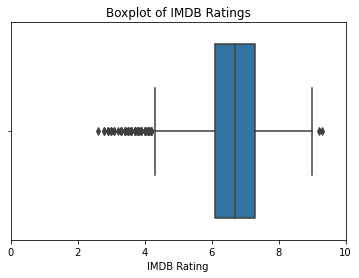

In [790]:
sns.boxplot(movie_Clean_DF['IMDB_Rating'])
plt.title('Boxplot of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.xlim(0, 10) 
plt.show()

In [793]:
movie_Clean_DF["IMDB_Rating"].mean()

6.595440631545108

C:\Users\micha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


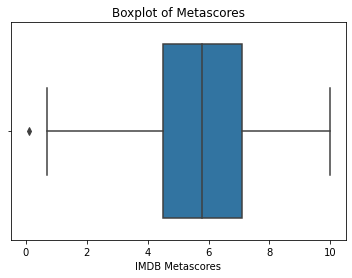

In [792]:
sns.boxplot(movie_Clean_DF['Metascore'])
plt.title('Boxplot of Metascores')
plt.xlabel('IMDB Metascores')
plt.xlim(-0.5, 10.5) 
plt.show()

In [794]:
movie_Clean_DF["Metascore"].mean()

5.76244562590621

As you can see, there are no impossible values since both boxplots have all of their values between 0 – 10. The mean of all the IMDB ratings is around 6.5 and for the Metascores it’s around 5.7. The IMDB ratings have a couple of outliers below a rating of around 4.3 and above 9. The Metascores only have outliers below 1. It seems that the Metascores are a bit more skewed to the left. 

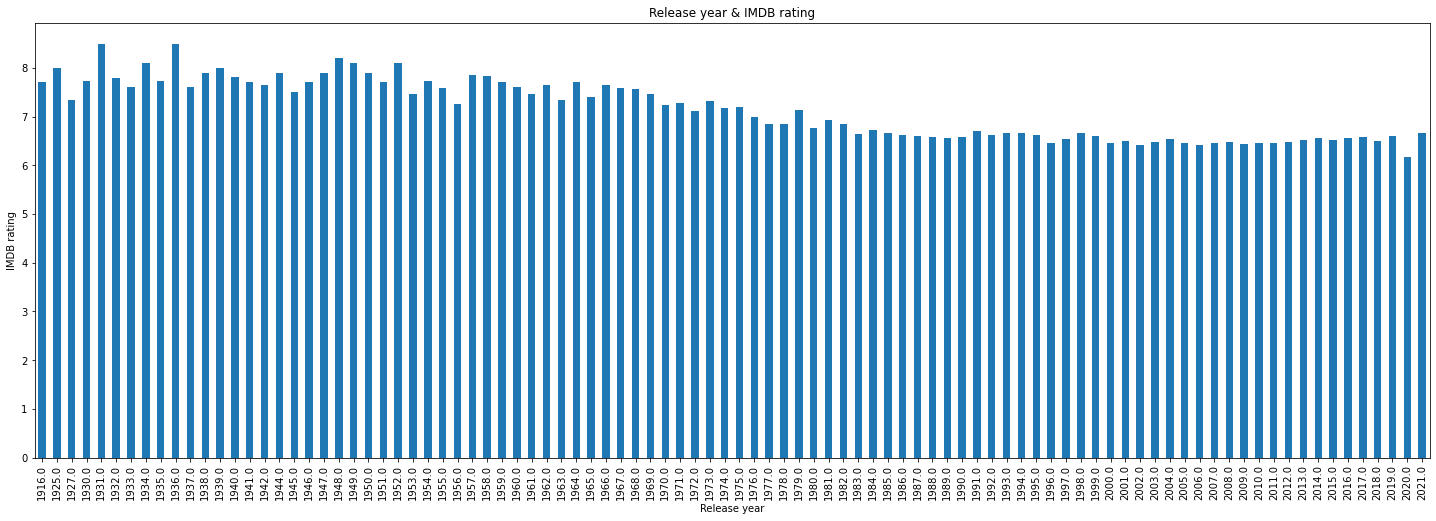

In [783]:
by_year = movie_Clean_DF.groupby('Release_Year').mean()
plt.figure(figsize=(25,8))
by_year['IMDB_Rating'].plot(kind='bar')
plt.title('Release year & IMDB rating')
plt.xlabel('Release year')
plt.ylabel('IMDB rating')
plt.show()

It doesn’t seem that the release year has a lot of effect on the IMDB rating itself. But we can see that the earlier movies tend to be a bit higher rated.

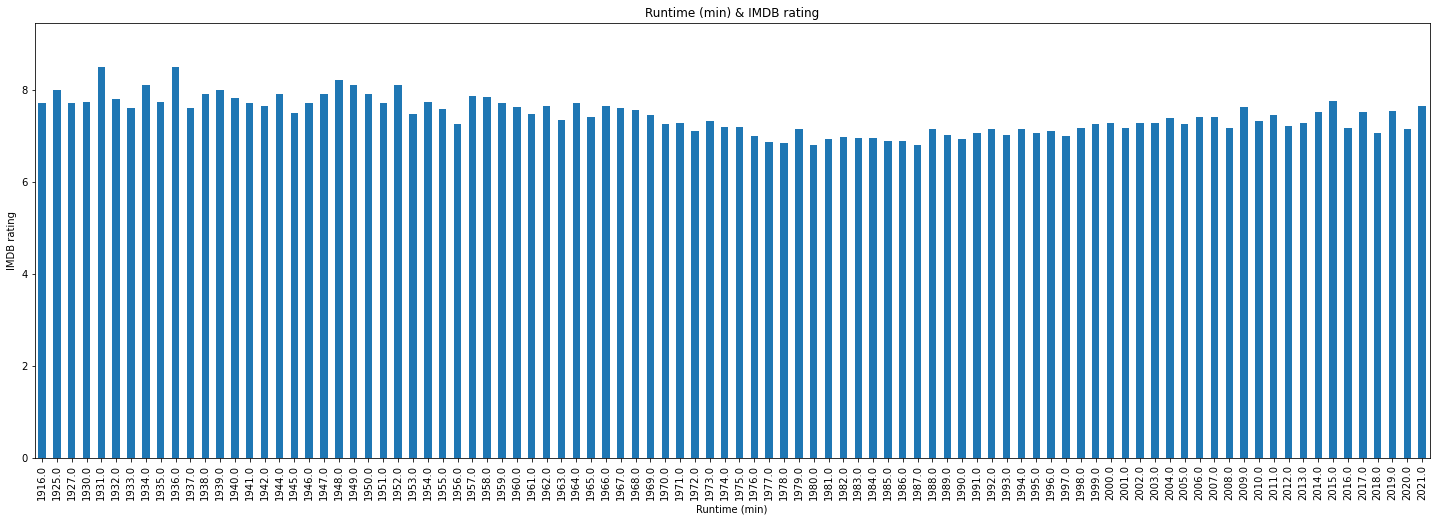

In [784]:
by_Runtime = movie_Clean_DF.groupby('Runtime_(min)').mean()
plt.figure(figsize=(25,8))
by_Runtime['IMDB_Rating'].plot(kind='bar')
by_year['IMDB_Rating'].plot(kind='bar')
plt.title('Runtime (min) & IMDB rating')
plt.xlabel('Runtime (min)')
plt.ylabel('IMDB rating')
plt.show()

Runtime doesn’t seem to be affecting the rating very much, since all of the ratings per runtime seem to be between a rating of 7-8, with a couple of exceptions. 

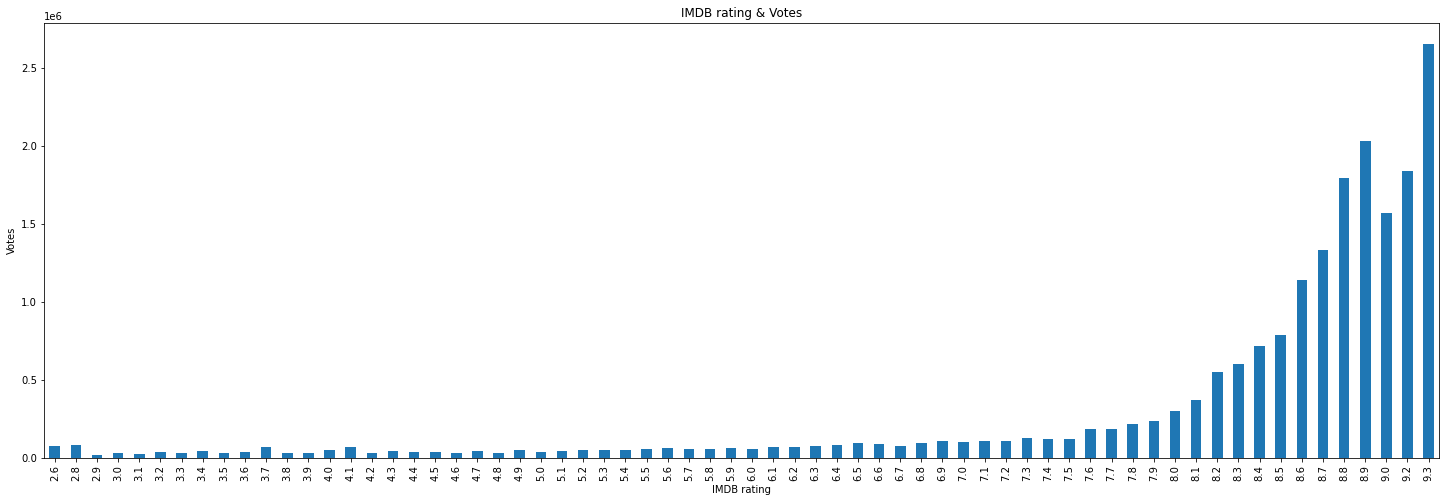

In [785]:
by_rating = movie_Clean_DF.groupby('IMDB_Rating').mean()
plt.figure(figsize=(25,8))
by_rating['Votes'].plot(kind='bar')
plt.title('IMDB rating & Votes')
plt.xlabel('IMDB rating')
plt.ylabel('Votes')
plt.show()

We can clearly see that a higher-rated movie has more votes than a low-rated movie. This makes it very easy to predict, that a movie with a lot of votes is probably a high-rated movie and vice versa. 

Finaly, lets take a look at the relation between all of the values!

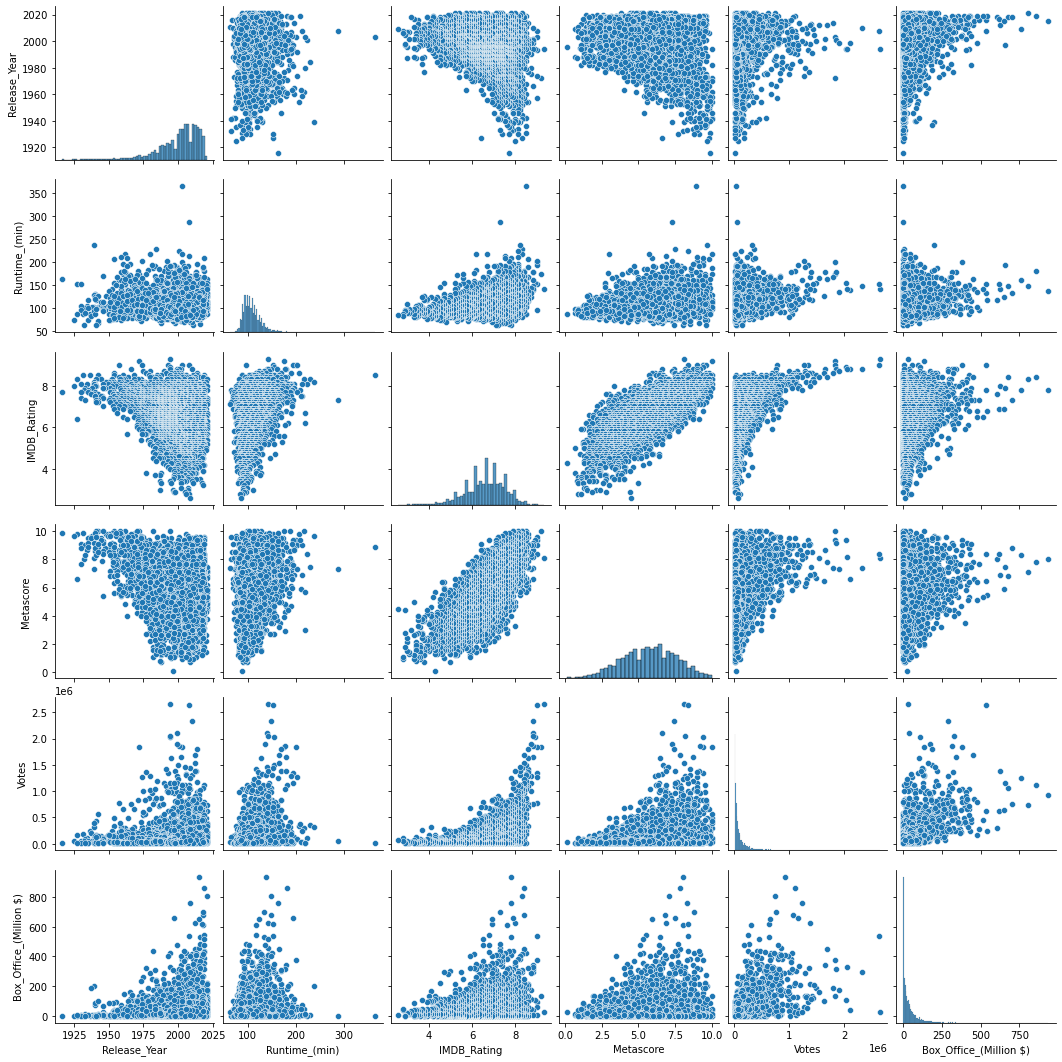

In [695]:
df_numerical = movie_Clean_DF[['Release_Year','Runtime_(min)','IMDB_Rating', 'Metascore', 'Votes', 'Box_Office_(Million $)']]
sns.pairplot(df_numerical)
plt.show()

<AxesSubplot:>

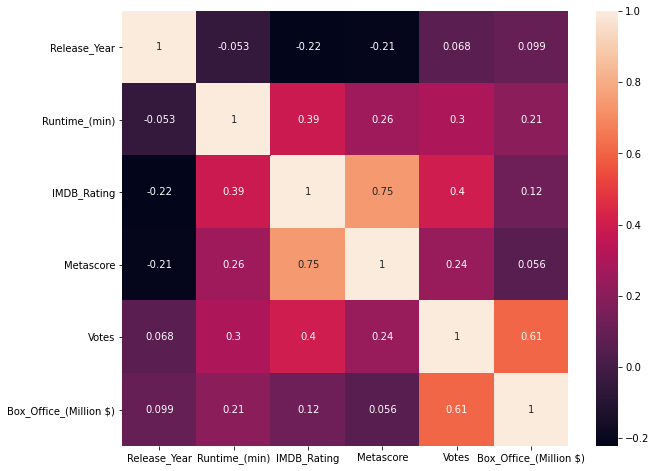

In [697]:
plt.figure(figsize=(10,8))
sns.heatmap(df_numerical.corr(),annot=True)

We can say that there is a correlation between a couple of variables. There is a positive moderate correlation between 
Metascore and IMDB ranking (0.75) and Votes and Box Office (0.61). And there is a positive low correlation between IMDB Rating and votes (0.4), Runtime and IMDB Rating (0.39) and Runtime and Votes (0.3). 

## 5. Predictive model

I have gathered all my data, so I will start training my model. I have chosen the Random Forest regression Algorithm because I am predicting a regression and not a class. And I think that using Random Forest will be better than using KNN because it would probably take more time to calculate and will not provide a better prediction. 

If have split the data into a train (70%) and test (30%). I will use the Release year, runtime (min), Metascore, votes, and Box Office to predict the IMDB rating of movies. I've set a random_state because Random Forest uses randomness, and we want a stable result for the purposes of presentation. I've set the number of trees to 100 since the computing power is able to handle this quantity of n_estimators.

In [714]:
X = movie_Clean_DF[['Release_Year','Runtime_(min)', 'Metascore', 'Votes', 'Box_Office_(Million $)']] 
y = movie_Clean_DF['IMDB_Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [710]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 1)
rf.fit(X_train, y_train);

Now my model is trained and able to predict the IMDB rating (Y) with the presented variables (X).

## 6. Evaluation

Now I'm going to make predictions on the test set and calculate the RMSE. 

In [724]:
y_test_p = rf.predict(X_test)

RMSE = math.sqrt(mean_squared_error(y_test, y_test_p))

VS_Rating = RMSE - ABE_rating
VS_Meta = RMSE - ABE_meta

print('The RMSE of the prediction model is:', round(RMSE,2))
print('The difference between the RMSE of the model and the baseline error of the IMDB rating is:', round(VS_Rating,2), "and with the baseline error of the Metascore is", round(VS_Meta,2))

The RMSE of the prediction model is: 0.52
The difference between the RMSE of the model and the baseline error of the IMDB rating is: -0.4 and with the baseline error of the Metascore is -0.75


My Prediction model is has performed better then than the baselines I had set. 

Now I will calculate the R^2 .

In [731]:
r2 = r2_score(y_test, y_test_p)
print('R2 is', round(r2,2), ", meaning ", round((r2*100),1), "% of variation is explained by the model")

R2 is 0.67 , meaning  66.8 % of variation is explained by the model


Let's see how the predicted values compare to the actual values.

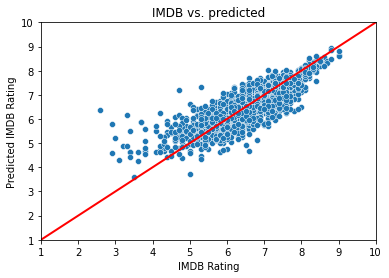

In [739]:
sns.scatterplot(x=y_test,y=y_test_p)
plt.xlim(1, 10) 
plt.ylim(1, 10) 
plt.plot([0, 1.5e6], [0, 1.5e6], color='red', lw=2) 
plt.xlabel('IMDB Rating')
plt.ylabel('Predicted IMDB Rating')
plt.title('IMDB vs. predicted')
plt.show()

#### Conclusion

We can predict 66.8% of the variation in the IMDB Rating based on the variables. Our typical prediction is off by a rating of 0.52s. We can see in the Y-Y' plot, that the model predicts lower-ranking movies too high, and from a ranking of around 5.5 its starts to even out. Although the prediction model is able to predict thousands of movies correctly, I'm not sure if I think this would be very useful in a practical context. It did beat both baseline errors that I had set, I wished that the prediction could be a bit more precise.

## 7. References

* Biramane, V., Kulkarni, H., Bhave, A., & Kosamkar, P. (2016). Relationships between classical factors, social factors and box office collections. *2016 International Conference on Internet of Things and Applications (IOTA)*, 35–39. https://doi.org/10.1109/IOTA.2016.7562691

              
* Moon, S., Bergey, P. K., & Iacobucci, D. (2010). Dynamic Effects among Movie Ratings, Movie Revenues, and Viewer Satisfaction. *Journal of Marketing, 74(1)*, 108–121. https://doi.org/10.1509/jmkg.74.1.108

